In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# Create a base for your automapped classes
Base = automap_base()

# Reflect the existing database using the engine
Base.prepare(engine, reflect = True)

# Display the automapped classes from the reflected model
for table_name, table_class in Base.classes.items():
    print(f"Table: {table_name}")
    for column in table_class.__table__.columns:
        print(f"  Column: {column.name}, Type: {column.type}")


Table: measurement
  Column: id, Type: INTEGER
  Column: station, Type: TEXT
  Column: date, Type: TEXT
  Column: prcp, Type: FLOAT
  Column: tobs, Type: FLOAT
Table: station
  Column: id, Type: INTEGER
  Column: station, Type: TEXT
  Column: name, Type: TEXT
  Column: latitude, Type: FLOAT
  Column: longitude, Type: FLOAT
  Column: elevation, Type: FLOAT


In [6]:
# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station


In [7]:
# View all of the classes that automap found

for table_name, table_class in Base.classes.items():
    print(f"Table Name: {table_name}")


Table Name: measurement
Table Name: station


In [8]:
# Save references to each table

# Create a dictionary to store references to the table classes
table_classes = {}

# Iterate through the automapped classes and store them in the dictionary
for table_name, table_class in Base.classes.items():
    table_classes[table_name] = table_class

# Measurement Table
measurement_table = table_classes["measurement"]

# Station Table
station_table = table_classes["station"]


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement_table.date)).scalar()

# The most recent date
print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Calculate the start date for the 12-month period
start_date = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1, months=0, days=0)).strftime('%Y-%m-%d')


In [12]:
# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame with column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("Date")


In [13]:
# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame with column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("Date")

C:\Users\TLCLa\anaconda3\envs\dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


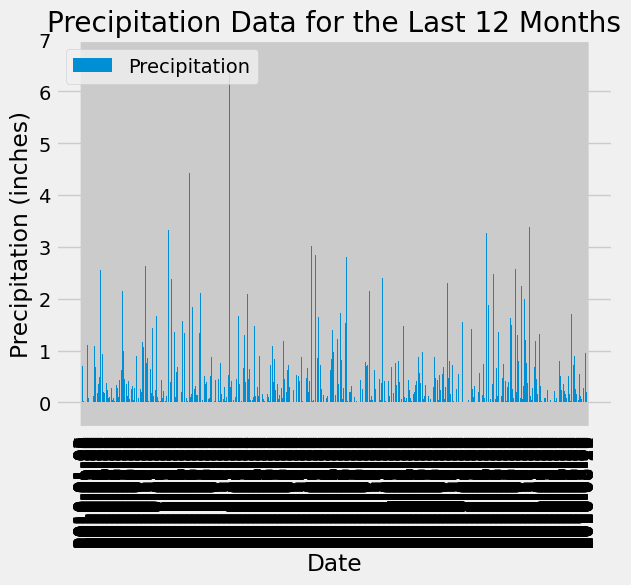

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precipitation_df["Date"], precipitation_df["Precipitation"], label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Data for the Last 12 Months")
# plt.locator_params(axis='x', nbins=5)
plt.ylim(-.5,7)
plt.xticks(rotation=90)
plt.legend()


plt.show()


In [15]:
# NOTE: This table is NOT correct. But I don't understand what I'm doing wrong to know how to fix it?

# NOTE: Fellow studen Katy Yelle suggested the following article to help solve the issue with my Precipitation Plot: https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks/49714879#49714879
# I could not make the incorporated ideas from the Stack Overflow article work. It errored out at pyplot.locator_params, saying no such function was defined. 

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df["Precipitation"].describe()

# Display the summary statistics
print(summary_statistics)


count    16088.000000
mean         0.158662
std          0.469771
min          0.000000
25%          0.000000
50%          0.010000
75%          0.100000
max         11.530000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print(f"The total number of stations in the dataset is: {total_stations}")


The total number of stations in the dataset is: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


# Design a query to find the most active stations and their counts
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order
print("Most Active Stations (in descending order):")
for station, count in active_stations:
    print(f"Station ID: {station}, Count: {count}")

Most Active Stations (in descending order):
Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Find the most active station (as calculated in the previous query)
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Unpack the station ID from the result
most_active_station_id = most_active_station[0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_data = session.query(func.min(Measurement.tobs),
                                 func.max(Measurement.tobs),
                                 func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).first()

In [20]:
# Unpack the result
lowest_temperature = temperature_data[0]
highest_temperature = temperature_data[1]
average_temperature = temperature_data[2]

# Print the results
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temperature} F")
print(f"Highest Temperature: {highest_temperature} F")
print(f"Average Temperature: {average_temperature} F")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most active station (as calculated in the previous query)
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Unpack the station ID from the result
most_active_station_id = most_active_station[0]

# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Retrieve the temperature observation data for the last 12 months for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=["Temperature (F)"])


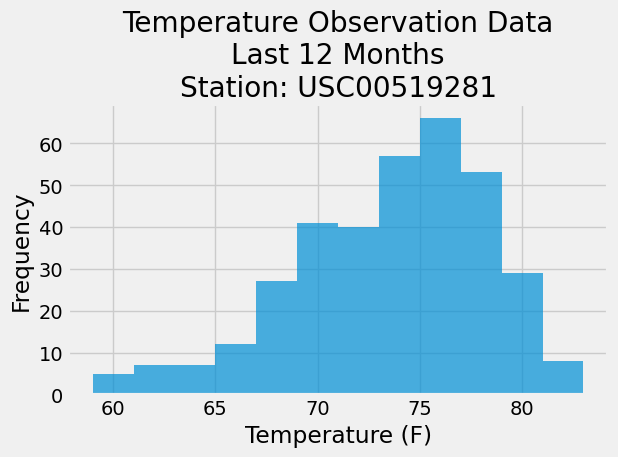

In [22]:
# Create a histogram plot
plt.hist(temperature_df["Temperature (F)"], bins=12, alpha=0.7)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observation Data\nLast 12 Months\nStation: {most_active_station_id}")
plt.tight_layout()
plt.show()

# Close Session

In [23]:
# Close Session
session.close()